/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


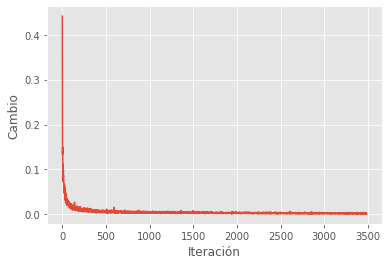

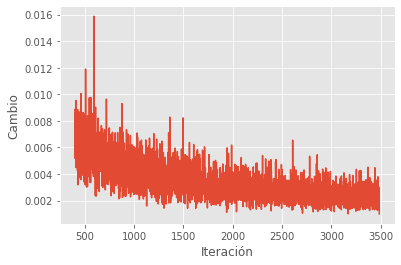

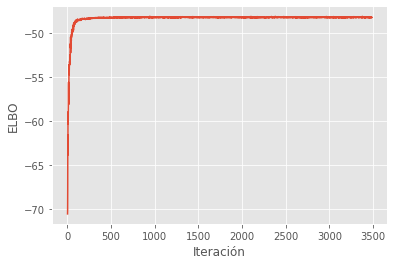

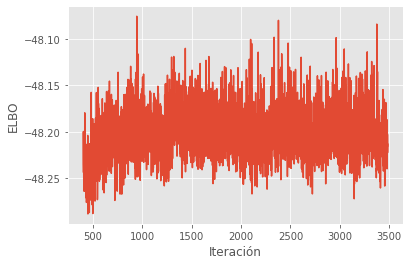

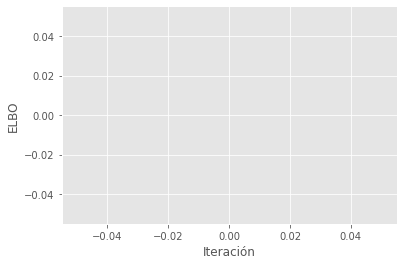

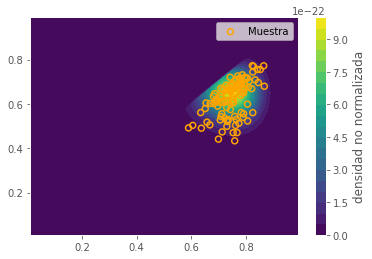

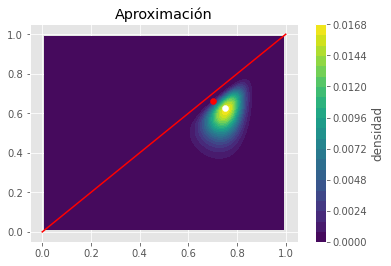

Segundos entrenamiento: 465.3284220000005
Minutos entrenamiento: 7.7554737000000085

Segundos muestreo: 0.0028879999999844586
Minutos muestreo: 4.8133333333074306e-05

Segundos total: 465.3313100000005
Minutos total: 7.755521833333342


iteraciones: 3487
media: [0.75022986 0.62458656]

Reales
medias: [0.7  0.66]
Último error:  0.00099578598072477

Diferencia: 0.00099578598072477


In [5]:
#ADVI full rank

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
import time
from scipy import special
from scipy import random
from scipy import stats
from decimal import *
import mpmath as mp
import math

plt.style.use('ggplot')

getcontext().prec = 62
tim_ini=time.clock()

s=345 #semilla

np.random.seed(s)
pars=2 # número de parámetros
tam=100 # Monte Carlo
tam_m=100 #muestra aproximante
t=1
n_a=40 # número de observaciones provenientes de theta A
n_b=40 # número de observaciones provenientes de theta B
theta_r=np.array([0.7,0.66])
x=np.random.binomial(1,theta_r[0],size=n_a) # observaciones provenientes de theta A
y=np.random.binomial(1,theta_r[1],size=n_b) # observaciones provenientes de theta B
s_a=np.sum(x)
s_b=np.sum(y)

mu=np.zeros(pars) # se inicializa media de distribución aproximante
iden=np.zeros((pars,pars))
for i in range(pars):
  iden[i,i]=1.0
L=iden.copy() # se inicializa matriz de covarianza de distribución aproximante
L_cov=L.copy()

dif=1.0
elbo=np.array([])
lambdas=np.array([]) # vector para guardar cambio en parámetros
tiempo=np.array([])

step=0.1 # parámetro tasa de aprendizaje adaptativa
rr=10**-16 # parámetro tasa de aprendizaje adaptativa
tr=1.0 # parámetro tasa de aprendizaje adaptativa
alf=0.1 # parámetro tasa de aprendizaje adaptativa

sss_mu=np.zeros((pars,2)) # arreglo para guardar y calcular de tasa de aprendizaje para vector de medias
sss_L=np.zeros((pars,pars)) # arreglo para guardar y calcular de tasa de aprendizaje para matriz de covarianzas
sss_L_aux=np.zeros((pars,pars)) # auxiliar para calcular de tasa de aprendizaje para matriz de covarianzas

while dif>10**-3:
  theta=np.zeros((2,tam)) # generación observaciones para Monte Carlo
  parcial_mu_acum=np.zeros(pars) # variable para acumular gradientes respecto a media
  parcial_L_acum=np.zeros((pars,pars)) # variable para acumular gradientes respecto a matriz de covarianza
  elb=np.zeros(tam) # variable para elbo
  L_inv=np.linalg.inv(L_cov)
  L_inv_trans=L_inv.transpose() # se obtiene transpuesta de la inversa de L
  for j in range(tam):
    eta=mvn.rvs(mean=np.zeros(pars),cov=iden) # generación de normal estándar
    temp=np.resize(eta,(pars,1))  
    zeta=np.linalg.multi_dot((L_cov,temp))+np.resize(mu,(pars,1)) # se obtienen variables latentes con soporte no restringido
    theta[0,j]=np.exp(zeta[0,0])/(1.0+np.exp(zeta[0,0])) # se obtienen variables latentes originales
    theta[1,j]=np.exp(zeta[0,0]+zeta[1,0])/((1.0+np.exp(zeta[0,0]))*(1.0+np.exp(zeta[1,0]))) # se obtienen variables latentes originales
    parcial_theta=np.zeros(pars)
    parcial_inv_theta=np.zeros((pars,pars))
    parcial_det_theta=np.zeros(pars)

    elb[j]+=s_a*np.log(theta[0,j])+(n_a-s_a)*np.log(1.0-theta[0,j])+s_b*np.log(theta[1,j])+(n_b-s_b)*np.log(1-theta[1,j])
    elb[j]+=-mvn.logpdf(zeta[:,0],mean=mu,cov=np.linalg.multi_dot((L_cov,L_cov.transpose())))

    parcial_theta[0]=s_a/theta[0,j]-(n_a-s_a)/(1-theta[0,j]) # derivada parcial de logverosimilitud respecto a theta A
    parcial_theta[1]=s_b/theta[1,j]-(n_b-s_b)/(1-theta[1,j]) # derivada parcial de logverosimilitud respecto a theta B

    parcial_det_theta[0]=2.0-3.0*np.exp(zeta[0,0])/(1.0+np.exp(zeta[0,0])) # derivada parcial de logaritmo del determinante respecto a zeta_1
    parcial_det_theta[1]=1.0-2.0*np.exp(zeta[1,0])/(1.0+np.exp(zeta[1,0])) # derivada parcial de logaritmo del determinante respecto a zeta_2

    parcial_inv_theta[0,0]=(np.exp(zeta[0,0])*(1.0+np.exp(zeta[0,0]))-np.exp(2.0*zeta[0,0]))/(1.0+np.exp(zeta[0,0]))**2 # derivada parcial de theta A respecto a zeta_1
    parcial_inv_theta[1,1]=np.exp(zeta[0,0])/(1.0+np.exp(zeta[0,0]))*((np.exp(zeta[1,0])*(1.0+np.exp(zeta[1,0]))-np.exp(2.0*zeta[1,0]))/(1.0+np.exp(zeta[1,0]))**2) # derivada parcial de theta B respecto a zeta_2
    parcial_inv_theta[1,0]=np.exp(zeta[1,0])/(1.0+np.exp(zeta[1,0]))*((np.exp(zeta[0,0])*(1.0+np.exp(zeta[0,0]))-np.exp(2.0*zeta[0,0]))/(1.0+np.exp(zeta[0,0]))**2) # derivada parcial de theta B respecto a zeta_1

    aux_L=np.zeros((pars,pars)) # gradiente respecto a matriz de covarianza
    aux_mu=np.zeros(pars) # gradiente respecto a media
    aux_mu[0]=parcial_theta[0]*parcial_inv_theta[0,0] + parcial_theta[1]*parcial_inv_theta[1,0] + parcial_det_theta[0]
    aux_mu[1]=parcial_theta[1]*parcial_inv_theta[1,1] + parcial_det_theta[1]

    aux_L[0,0]=(parcial_theta[0]*parcial_inv_theta[0,0] + parcial_theta[1]*parcial_inv_theta[1,0] + parcial_det_theta[0])*eta[0]
    aux_L[1,1]=(parcial_theta[1]*parcial_inv_theta[1,1] + parcial_det_theta[1])*eta[1]
    aux_L[1,0]=(parcial_theta[1]*parcial_inv_theta[1,1] + parcial_det_theta[1])*eta[0]
        
    aux_L=aux_L+L_inv_trans
    parcial_mu_acum=parcial_mu_acum+aux_mu
    parcial_L_acum=parcial_L_acum+aux_L
  parcial_mu_acum=parcial_mu_acum/tam
  parcial_L_acum=parcial_L_acum/tam
  elb=np.median(elb)
  ss_mu=parcial_mu_acum**2
  ss_L=parcial_L_acum**2
  if t>1:
    sss_mu[:,0]=sss_mu[:,1]*(1-alf)+alf*ss_mu
    sss_L=sss_L_aux*(1-alf)+alf*ss_L
  else:
    sss_mu[:,0]=ss_mu.copy()
    sss_L=ss_L.copy()
  sss_mu[:,1]=sss_mu[:,0]
  sss_L_aux=sss_L.copy()
  ro_mu=step*t**(-0.5+rr)/(tr+np.sqrt(sss_mu[:,0])) # tasa de aprendizaje de media
  ro_L=step*t**(-0.5+rr)/(tr+np.sqrt(sss_L)) # tasa de aprendizaje de matriz de covarianza
  err_mu=ro_mu*parcial_mu_acum # cambio de media
  err_L=ro_L*parcial_L_acum # cambio de matriz de covarianza
  mu_aux=mu.copy()
  L_aux=L.copy()
  mu=mu+err_mu
  L=L+err_L
  L_cov=L.copy()
  aux2=np.linalg.multi_dot((L,L.transpose()))
  L=np.linalg.cholesky(aux2) 
  L_cov=L.copy()
  tiempo=np.concatenate([tiempo,np.array([t])])
  t+=1
  dif=np.sum(abs(err_mu))+np.sum(np.sum(abs(err_L)))
  lambdas=np.concatenate([lambdas,np.array([dif])])
  elbo=np.concatenate([elbo,np.array([elb])])

tim_entr=time.clock() #termina tiempo de entrenamiento

media=np.zeros(pars)
L_aux=L.copy()
temp_L=L.transpose()
covv=np.linalg.multi_dot((L,temp_L))
par=mvn.rvs(mean=mu,cov=covv,size=tam_m)
media[0]=np.mean(np.exp(par[:,0])/(1.0+np.exp(par[:,0]))) # se obtiene estimación puntual de theta A
media[1]=np.mean(np.exp(par[:,0]+par[:,1])/((1.0+np.exp(par[:,0]))*(1.0+np.exp(par[:,1])))) # se obtiene estimación puntual de theta B
L=L_aux.copy()

tim2=time.clock()
timf=tim2-tim_ini
tim_e=tim_entr-tim_ini
tim_e_mins=tim_e/60.0
timf_m=timf/60.0
tim_mues=tim2-tim_entr
tim_mues_mins=tim_mues/60.0


def mezcla(a,b):
  if b>0 and b <=a and a<1:
    f=s_a*np.log(a)+(n_a-s_a)*np.log(1-a)+s_b*np.log(b)+(n_b-s_b)*np.log(1-b)
    f=np.exp(f)
  else:
    f=0.0
  return f

def mezcla2(a,b):
  if a>b:
    a_t=np.log(a/(1.0-a))
    b_t=np.log(b/(a-b))
    f=mvn.logpdf((a_t,b_t),mean=mu,cov=covv)+2.0*a_t+b_t-2.0*np.array([mp.log(1.0+mp.exp(b_t))]).astype(float)[0]-3*np.array([mp.log(1.0+mp.exp(a_t))]).astype(float)[0]
    f=np.exp(f)
  else:
    f=0.0
  return f


plt.plot(tiempo[0:np.size(tiempo)],lambdas[0:np.size(lambdas)])
plt.ylabel("Cambio")
plt.xlabel("Iteración")
plt.show()

plt.plot(tiempo[400:np.size(tiempo)],lambdas[400:np.size(lambdas)])
plt.ylabel("Cambio")
plt.xlabel("Iteración")
plt.show()

plt.plot(tiempo,elbo)
plt.ylabel("ELBO")
plt.xlabel("Iteración")
plt.show()

plt.plot(tiempo[400:np.size(tiempo)],elbo[400:np.size(elbo)])
plt.ylabel("ELBO")
plt.xlabel("Iteración")
plt.show()

plt.plot(tiempo[8000:np.size(tiempo)],elbo[8000:np.size(elbo)])
plt.ylabel("ELBO")
plt.xlabel("Iteración")
plt.show()

parta=125
partb=125
Z=np.zeros((parta,partb))


ainf=0.01
asup=0.99
binf=0.01
bsup=0.99


a=0
for i in np.linspace(ainf,asup,parta):
    b=0
    for j in np.linspace(binf,bsup,partb):
        Z[a,b]=mezcla(i,j)
        b=b+1
    a=a+1

l1=np.linspace(0,1,num=10)
plt.contourf(np.linspace(ainf,asup,parta),np.linspace(binf,bsup,partb),np.transpose(Z),levels=20)
plt.colorbar().ax.set_ylabel('densidad no normalizada')
plt.scatter(np.exp(par[:,0])/(1.0+np.exp(par[:,0])),np.exp(par[:,0]+par[:,1])/((1.0+np.exp(par[:,0]))*(1.0+np.exp(par[:,1]))),marker='o',color="orange",facecolors='none',label='Muestra',linewidth=1.5)
#plt.scatter(theta_r[0],theta_r[1],facecolors="r")
plt.legend()
plt.show()

Z2=np.zeros((parta,partb))



a=0
for i in np.linspace(ainf,asup,parta):
    b=0
    for j in np.linspace(binf,bsup,partb):
        Z2[a,b]=mezcla2(i,j)
        b=b+1
    a=a+1


plt.contourf(np.linspace(ainf,asup,parta),np.linspace(binf,bsup,partb),np.transpose(Z2),levels=20)
plt.colorbar().ax.set_ylabel('densidad')
plt.scatter(np.mean(media[0]),np.mean(media[1]),facecolors="w")
plt.scatter(theta_r[0],theta_r[1],facecolors="r")
plt.plot(l1,l1,color="r")
plt.title("Aproximación")
plt.show()





print("Segundos entrenamiento: ", tim_e,sep="")
print("Minutos entrenamiento: ", tim_e_mins,sep="")
print("")
print("Segundos muestreo: ", tim_mues,sep="")
print("Minutos muestreo: ", tim_mues_mins,sep="")
print("")
print("Segundos total: ", timf,sep="")
print("Minutos total: ", timf_m,sep="")
print("")
print("")
print("iteraciones: ",t,sep="")
print("media: ",media,sep="")
print("")
print("Reales")
print("medias: ",theta_r,sep="")
print("Último error: ", lambdas[np.size(lambdas)-1])
print("")
print("Diferencia: ",dif,sep="")

